In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Roger Varney"
user_email = "roger.varney@sri.com"
user_affiliation = "SRI International"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://cedar.openmadrigal.org/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2012, 11, 1, 13,0)
et=datetime.datetime(2012, 11, 1, 15,0)

expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100060015
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100060015
url: http://cedar.openmadrigal.org/madtoc/experiments/2012/pfa/01nov12c
name: IPY27 - Long duration measurements in support of the International Polar Year
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2012
startmonth: 11
startday: 1
starthour: 7
startmin: 40
startsec: 37
endyear: 2012
endmonth: 11
endday: 1
endhour: 18
endmin: 25
endsec: 20
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1543545557
access: 2
Madrigal version: 3.0



In [5]:
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    if re.match('Alternating Code \(AC16-30\)',file.kindatdesc):
        acfile=file
        
filename=acfile.name
outfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [6]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']/np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [7]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64157.0 -154.3 77.5
64964.0 -34.69 66.09
65066.0 75.03 65.56


In [8]:
#find the up-B beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==77.5:
        bind=i
bdat=PFISR_data[bind]

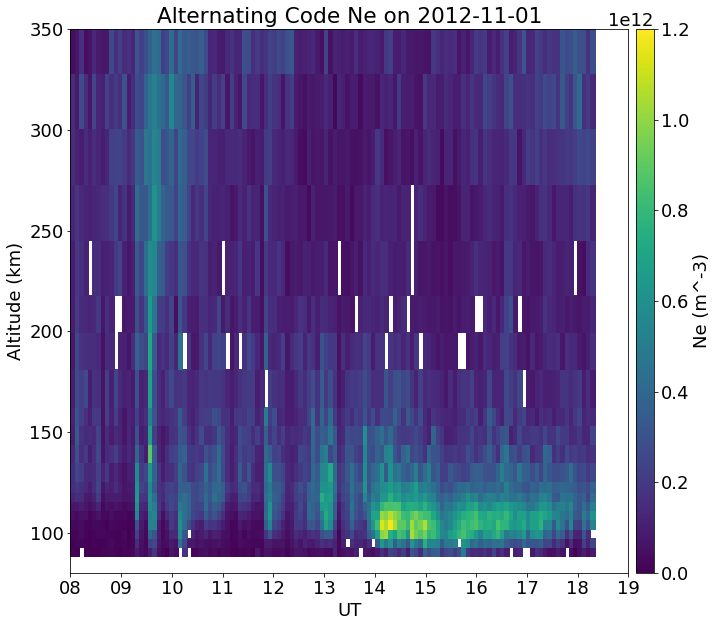

In [22]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,ax=plt.subplots(1,1)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=1.2e12)

ax.set_xlim([mdates.date2num(datetime.datetime(2012,11,1,8,0,0)),mdates.date2num(datetime.datetime(2012,11,1,19,0,0))])
ax.set_xticks(np.arange(mdates.date2num(datetime.datetime(2012,11,1,8,0,0)),mdates.date2num(datetime.datetime(2012,11,1,20,0,0)),1.0001/24.0))
ax.set_ylim([80,350])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Alternating Code Ne on 2012-11-01')

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')

Hint: SuperMAG includes 2012-11-01 13:52:00 UTC in one of their lists of special times

Also, the Poker Flat all sky camera is spectacular on this night.
http://optics.gi.alaska.edu/realtime/data/MPEG/PKR_DASC_256/2012/PKR_DASC_20121101_rgb.mpg